In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from helpers import create_polling_id
from epitools import get_data
from adjustText import adjust_text
from scipy.stats import pearsonr

# Robustness

In [8]:
# !python pipeline.py -y 2016 -c "United States" -l state -r senate -n 2
# !python pipeline.py -y 2020 -c "United States" -l state -r senate -n 2
!python pipeline.py -y 2016 -c "United States" -l state -r general -n 2
!python pipeline.py -y 2020 -c "United States" -l state -r general -n 2

!python pipeline.py -y 2016 -c "United States" -l state -r first_round -n 2
!python pipeline.py -y 2020 -c "United States" -l state -r first_round -n 2

ALABAMA
ALASKA
ARIZONA
ARKANSAS
CALIFORNIA
COLORADO
CONNECTICUT
DELAWARE
DISTRICT OF COLUMBIA
FLORIDA
GEORGIA
HAWAII
IDAHO
ILLINOIS
INDIANA
IOWA
KANSAS
KENTUCKY
LOUISIANA
MAINE
MARYLAND
MASSACHUSETTS
MICHIGAN
MINNESOTA
MISSISSIPPI
MISSOURI
MONTANA
NEBRASKA
NEVADA
NEW HAMPSHIRE
NEW JERSEY
NEW MEXICO
NEW YORK
NORTH CAROLINA
NORTH DAKOTA
OHIO
OKLAHOMA
OREGON
PENNSYLVANIA
RHODE ISLAND
SOUTH CAROLINA
SOUTH DAKOTA
TENNESSEE
TEXAS
UTAH
VIRGINIA
WASHINGTON
WEST VIRGINIA
WISCONSIN
WYOMING
ALABAMA
ALASKA
ARIZONA
ARKANSAS
CALIFORNIA
COLORADO
CONNECTICUT
DELAWARE
DISTRICT OF COLUMBIA
FLORIDA
GEORGIA
HAWAII
IDAHO
ILLINOIS
INDIANA
IOWA
KANSAS
KENTUCKY
LOUISIANA
MAINE
MARYLAND
MASSACHUSETTS
MICHIGAN
MINNESOTA
MISSISSIPPI
MISSOURI
MONTANA
NEBRASKA
NEVADA
NEW HAMPSHIRE
NEW JERSEY
NEW MEXICO
NEW YORK
NORTH CAROLINA
NORTH DAKOTA
OHIO
OKLAHOMA
OREGON
PENNSYLVANIA
RHODE ISLAND
SOUTH CAROLINA
SOUTH DAKOTA
TENNESSEE
TEXAS
UTAH
VIRGINIA
WASHINGTON
WEST VIRGINIA
WISCONSIN
WYOMING
ALABAMA
ALASKA
ARIZONA
ARKANSA

Here we read the ISO-2 codes for each state

In [6]:
df_codes = pd.read_csv("https://raw.githubusercontent.com/jackparmer/iso-3166-state-codes/master/codes.csv")
df_codes = df_codes.rename(columns={"code": "state_id"}).drop(columns=["category"])
df_codes["state"] = df_codes["state"].str.upper()
df_codes.head()

,state_id,state
0,AL,ALABAMA
1,AK,ALASKA
2,AZ,ARIZONA
3,AR,ARKANSAS
4,CA,CALIFORNIA


In [9]:
year = 2016

df_senate = get_data(
    country="United States",
    aggregation="state",
    election="senate",
    year=year
)
df_senate["state"] = df_senate["state"].str.upper()

df_presidential = get_data(
    country="United States",
    aggregation="state",
    election="general",
    year=year
)
df_presidential["state"] = df_presidential["state"].str.upper()

# df_house = get_data(
#     country="United States",
#     aggregation="state",
#     election="representatives",
#     year=year
# )
df_presidential["state"] = df_presidential["state"].str.upper()

df = pd.merge(df_presidential, df_senate, on=["state", "year"])
df = pd.merge(df, df_codes, on="state")

df.head()

,state,ec_x,ep_x,year,ec_y,ep_y,state_id
0,ALABAMA,0.459748,0.450486,2016,0.483821,0.417552,AL
1,ALASKA,0.698405,0.278445,2016,0.760741,0.169302,AK
2,ARIZONA,0.717409,0.275376,2016,0.722530,0.232782,AZ
3,ARKANSAS,0.560387,0.336748,2016,0.617185,0.284074,AR
4,COLORADO,0.686080,0.312928,2016,0.713871,0.284998,CO


In [12]:
data = df.copy()
for col in ["ep", "ec"]:
    data[f"{col}_x"] = (data[f"{col}_x"] - data[f"{col}_x"].mean()) / data[f"{col}_x"].std()
    data[f"{col}_y"] = (data[f"{col}_y"] - data[f"{col}_y"].mean()) / data[f"{col}_y"].std()

data = data.melt(id_vars=["state", "state_id", "year"])
data["type"] = data["variable"].str.replace("_x", "").str.replace("_y", "")
data["variable"] = data["variable"].str.replace("ec_", "").str.replace("ep_", "")

data = data.pivot(index=["state", "state_id", "year", "type"], columns=["variable"], values="value").reset_index()
data

variable,state,state_id,year,type,x,y
0,ALABAMA,AL,2016,ec,-1.953063,-1.526178
1,ALABAMA,AL,2016,ep,1.667773,1.761703
2,ALASKA,AK,2016,ec,0.725520,1.160451
3,ALASKA,AK,2016,ep,-0.445458,-1.208173
4,ARIZONA,AZ,2016,ec,0.938808,0.789741
...,...,...,...,...,...,...
59,UTAH,UT,2016,ep,0.584252,0.474691
60,WASHINGTON,WA,2016,ec,0.428282,1.547229
61,WASHINGTON,WA,2016,ep,0.054938,-0.868532
62,WISCONSIN,WI,2016,ec,0.834391,0.683869


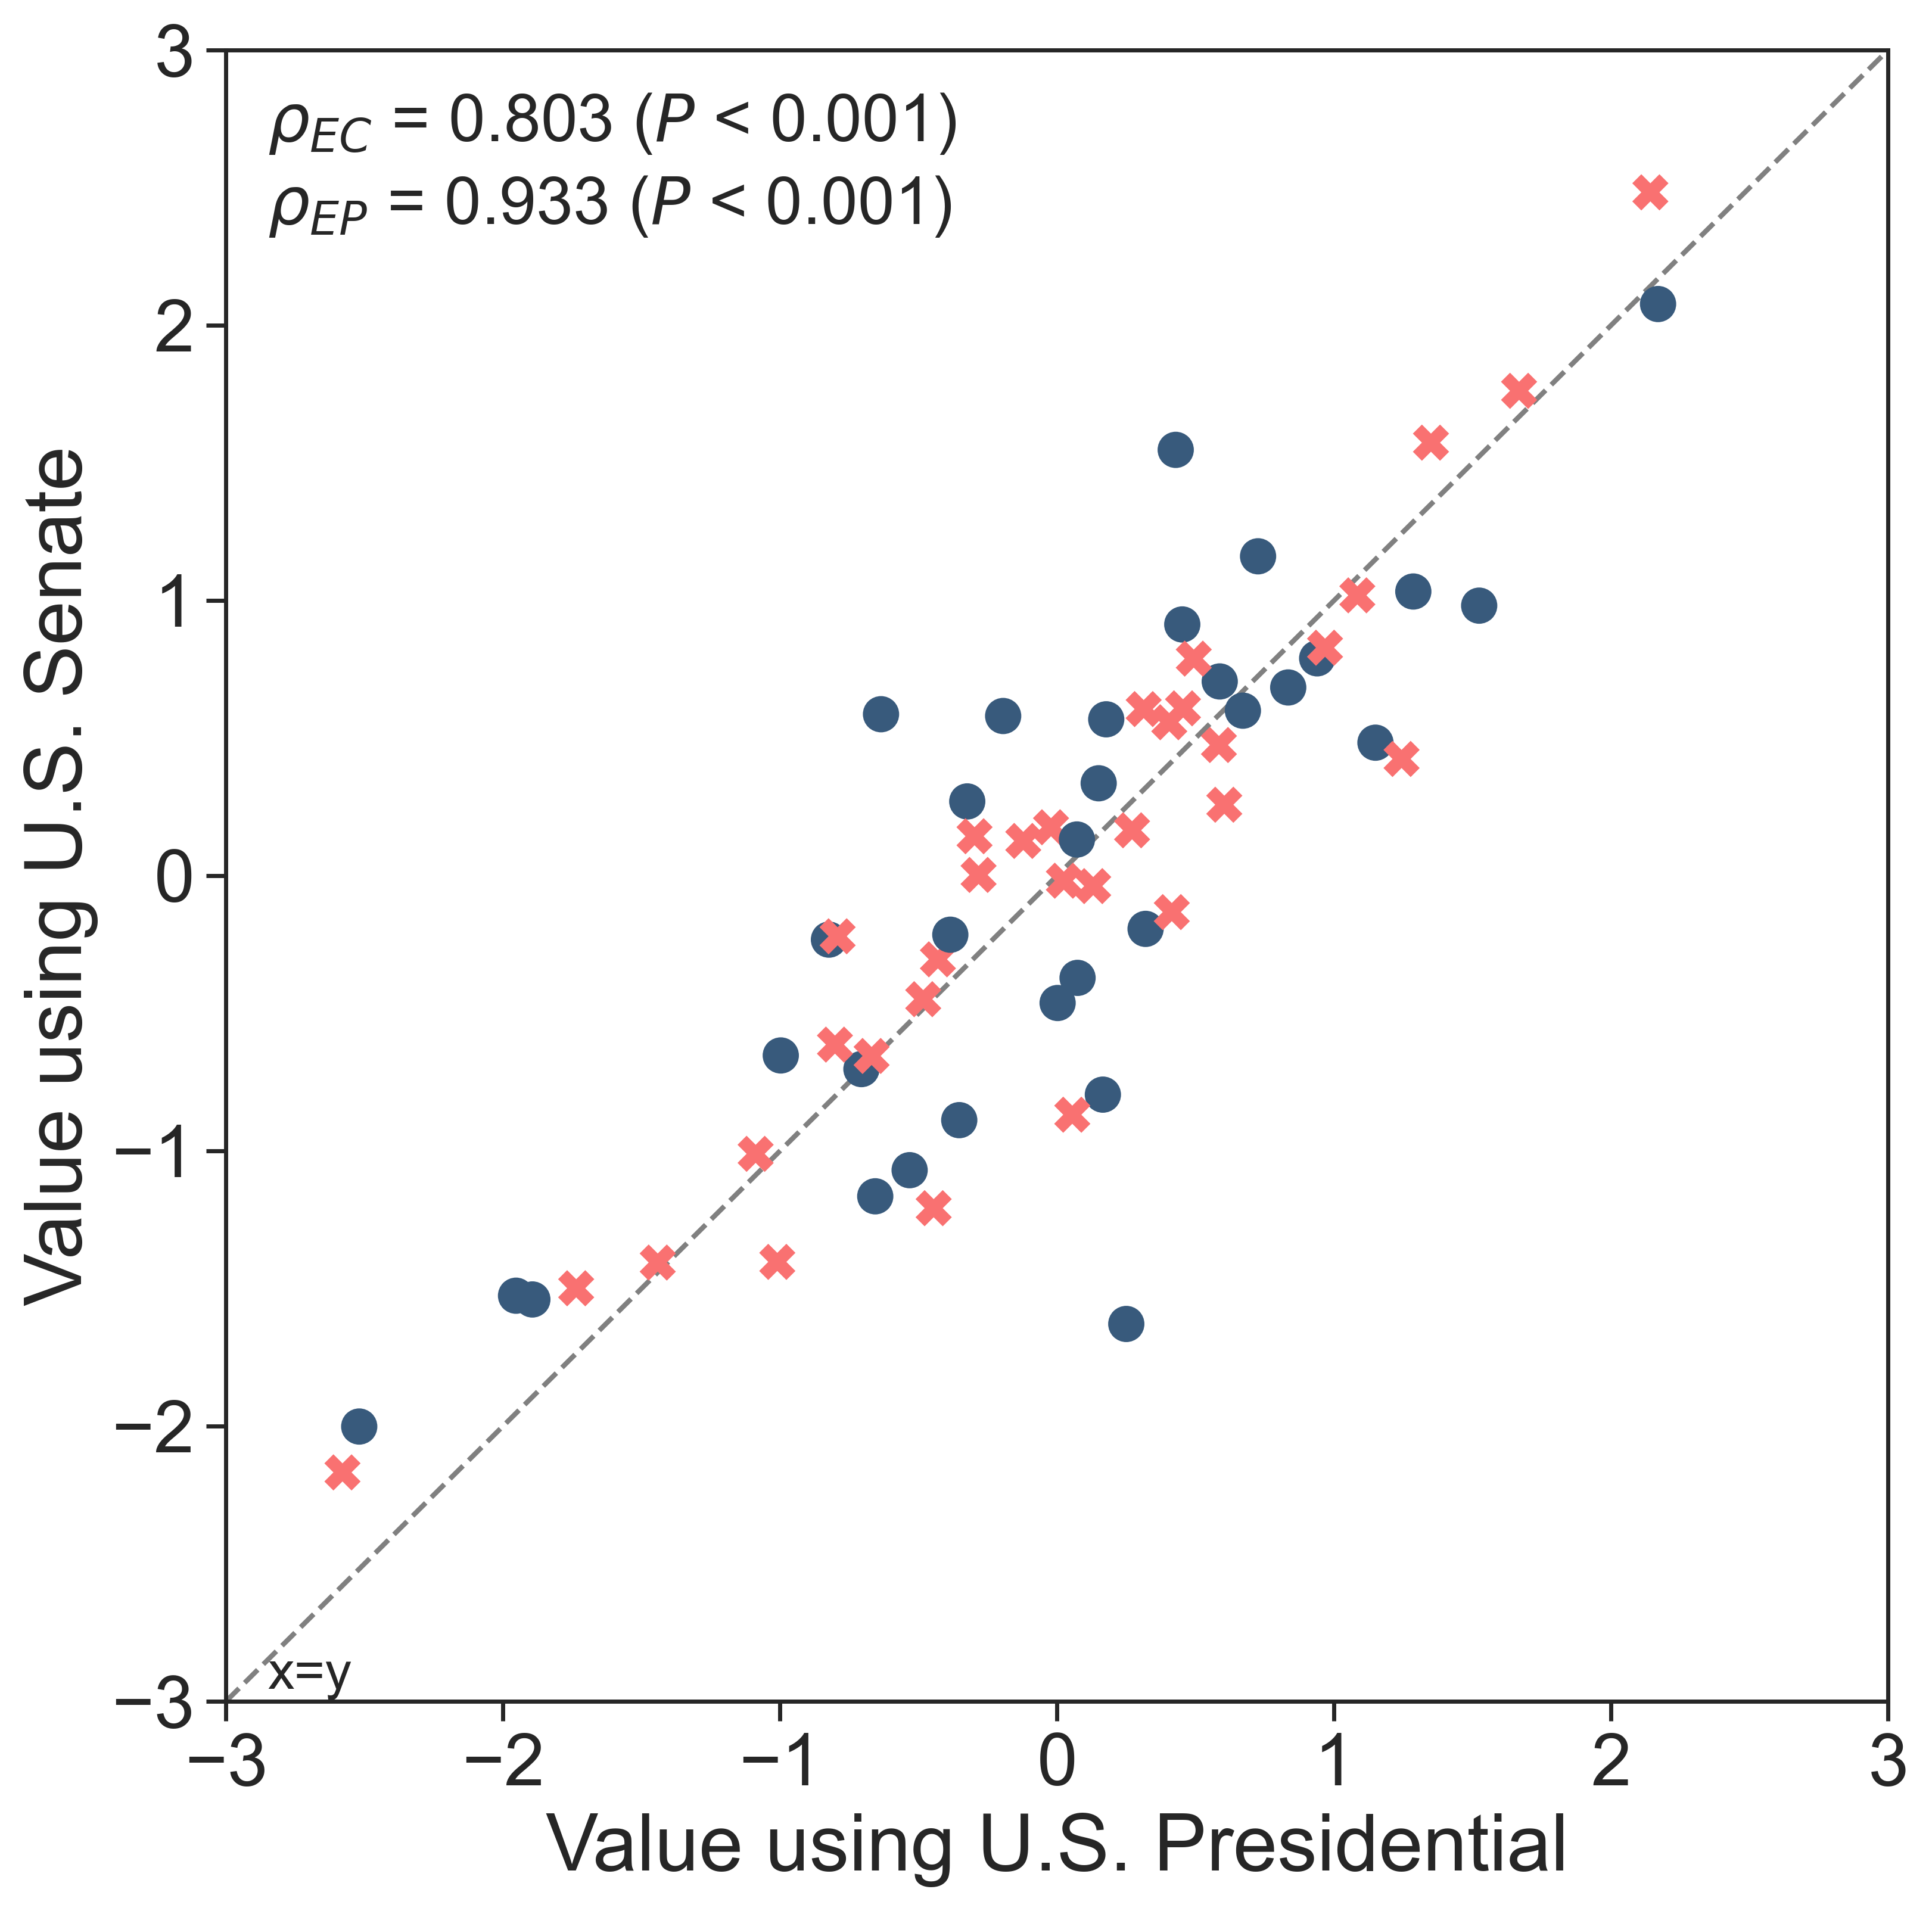

In [86]:
def set_plot(dt):
    sns.set(font_scale=2, style="ticks")

    fig, ax = plt.subplots(figsize=(9, 9), dpi=400)

    g = sns.scatterplot(
        x="x",  y="y", hue="type", 
        hue_order=["ec", "ep"], 
        style="type", 
        s=120,
        linewidth=0,
        palette=["#385a7c", "#f97171"], 
        legend=False,
        data=dt, zorder=2
    )
    g.set_xlabel("Value using U.S. Presidential")
    g.set_ylabel("Value using U.S. Senate")

    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)

    ax.plot([0, 1], [0, 1], color="gray", ls="--", transform=ax.transAxes, zorder=1)


    pos = 0.975
    for i, dd in dt.groupby("type"):
        corr, pvalue = pearsonr(dd["x"], dd["y"])
        def corrfunc(pvalue):
            if pvalue < 0.001:
                return "$P$ < 0.001"
            else:
                return f"$P$ = {round(pvalue, 3)}"

        labels = {"ec": "EC", "ep": "EP"}
        val = corrfunc(pvalue)
        
        ax.text(0.025, pos, f"$ρ_{{{labels[i]}}}$ = {round(corr, 3)} ({val})", transform=ax.transAxes, va="top", fontsize=20)
        pos -= 0.05

    ax.text(0.025, 0.03, "x=y", transform=ax.transAxes, va="top", fontsize=16)

set_plot(data)

### Robustness Maximal Aggregation Unit

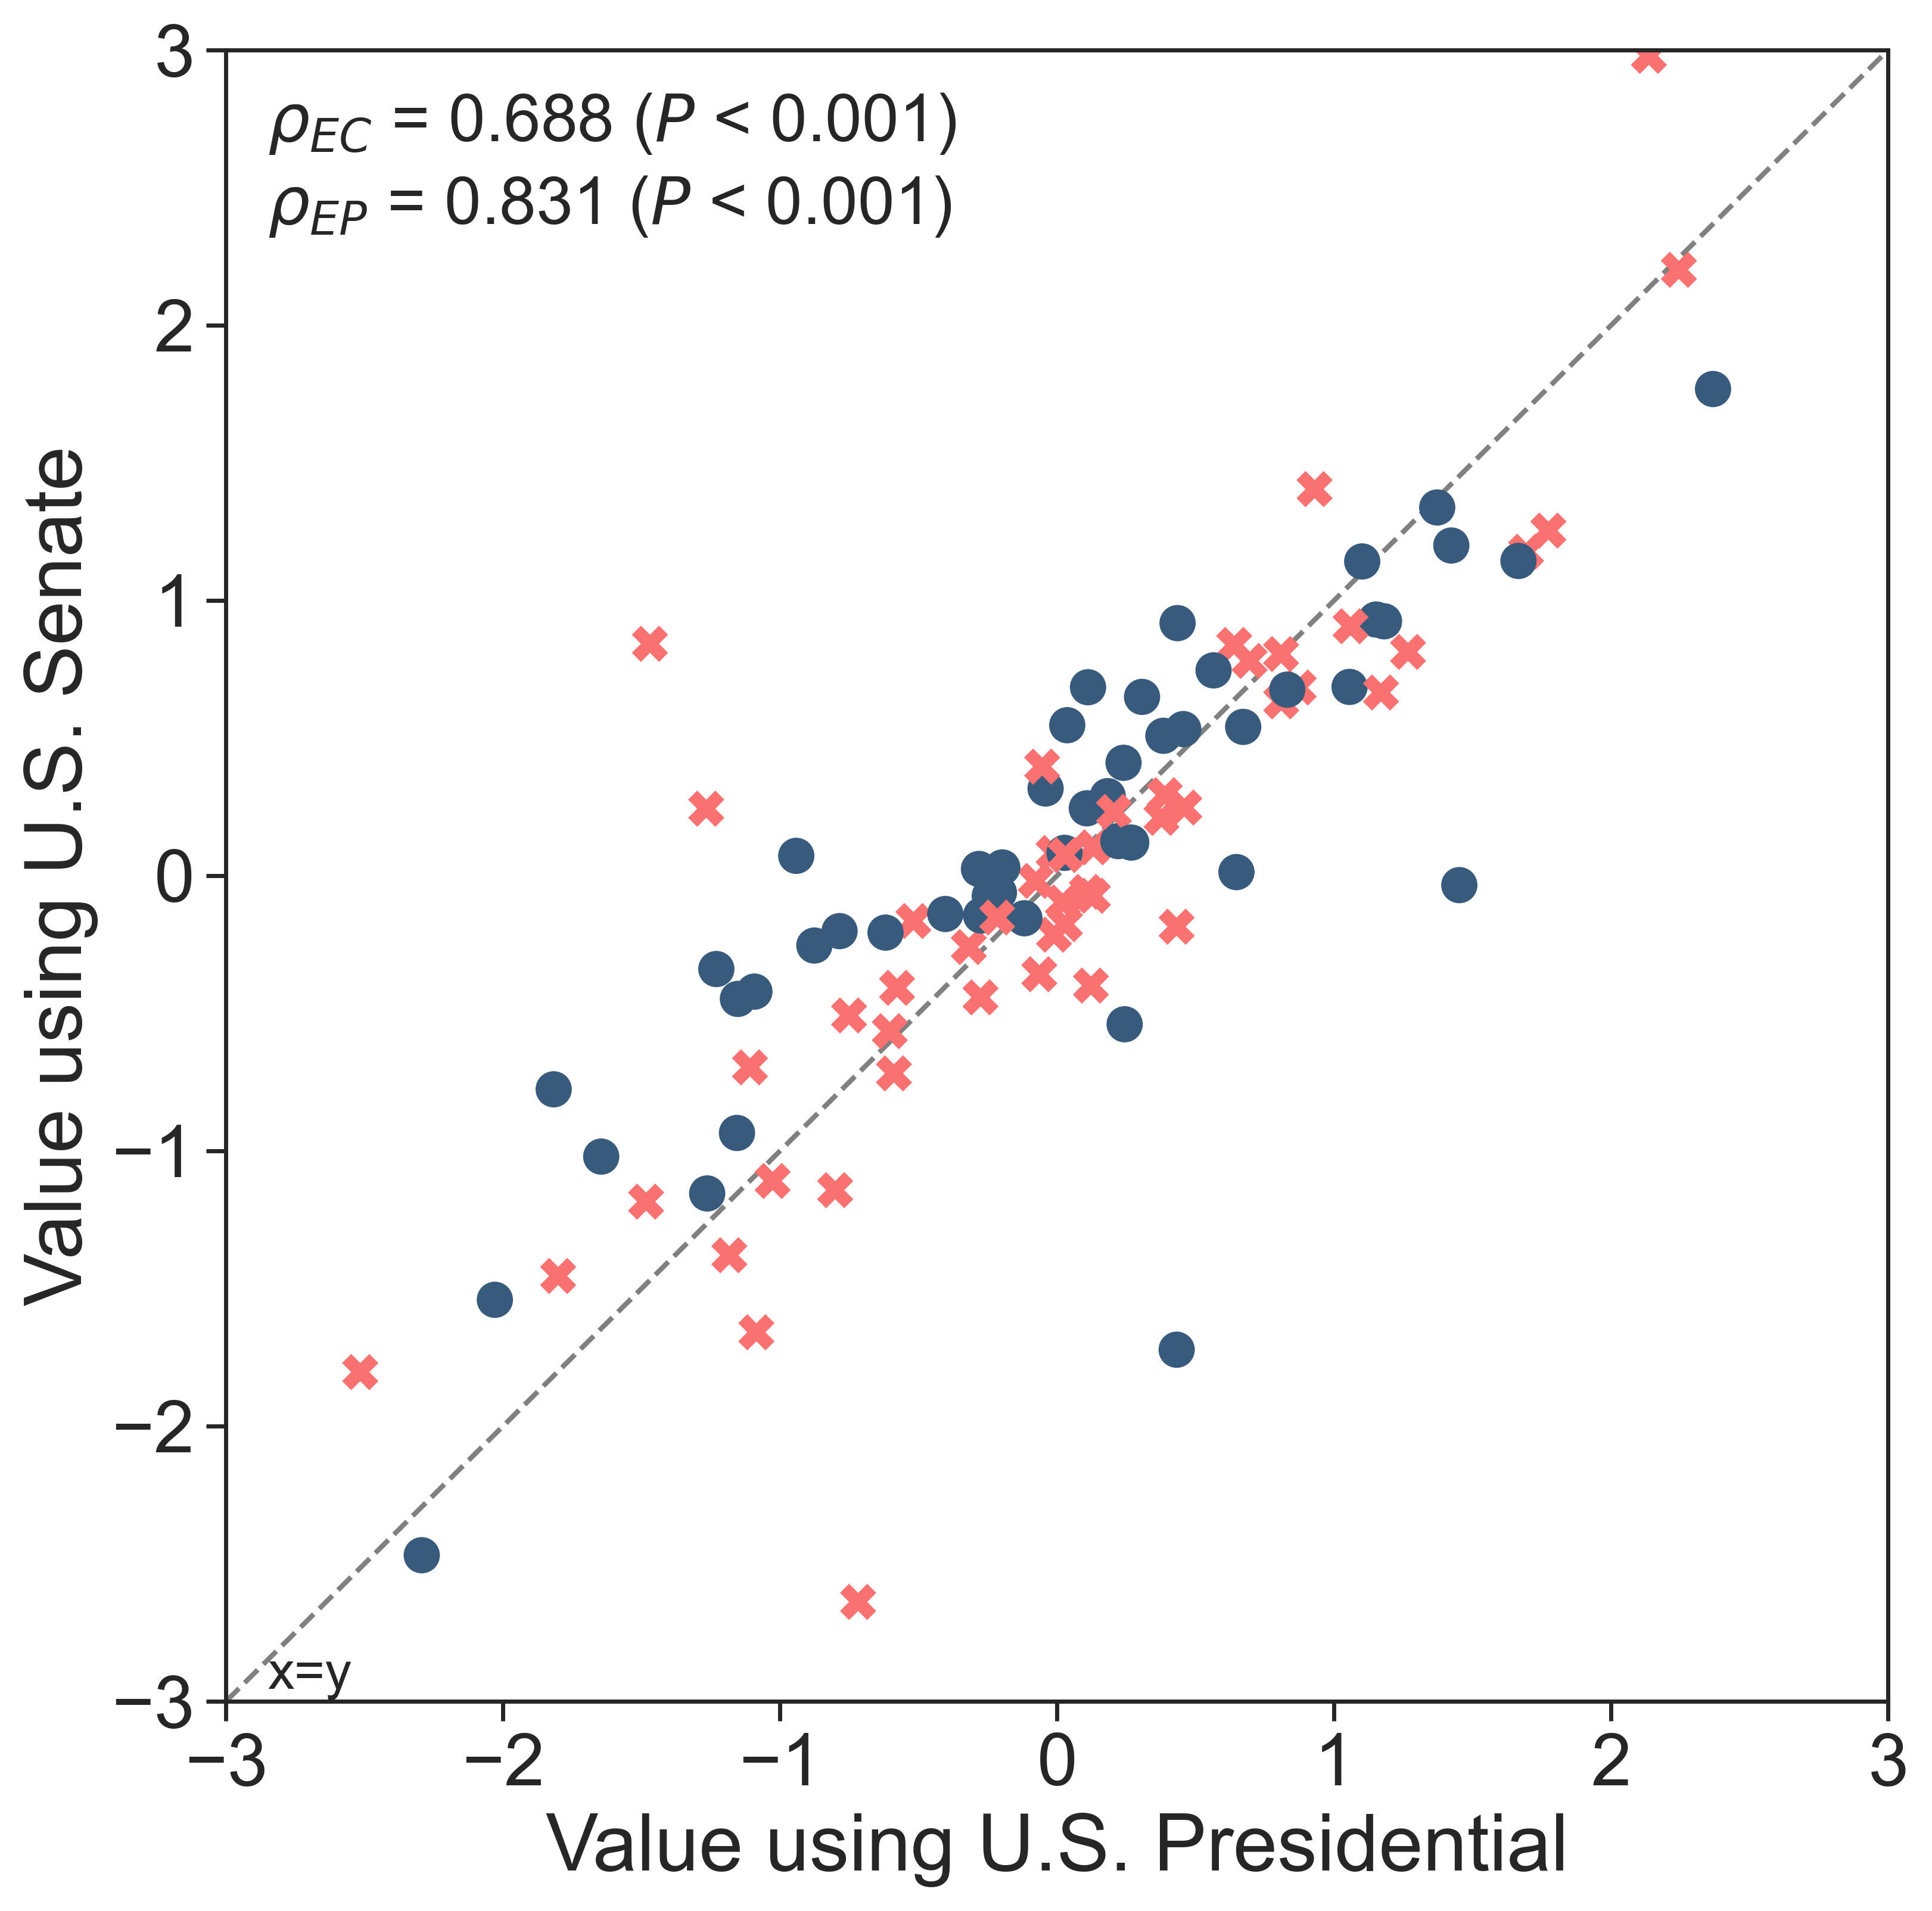

In [90]:
year = 2020
df_presidential = get_data(
    country="United States",
    aggregation="state",
    election="general",
    year=year
)
df_presidential["state"] = df_presidential["state"].str.upper()

df_house = get_data(
    country="United States",
    aggregation="state",
    election="representatives",
    year=year
)
df_house["state"] = df_house["state"].str.upper()

df = pd.merge(df_presidential, df_house, on=["state", "year"])
df = pd.merge(df, df_codes, on="state")

data = df.copy()
data = data[data["state"] != "DISTRICT OF COLUMBIA"]
for col in ["ep", "ec"]:
    data[f"{col}_x"] = (data[f"{col}_x"] - data[f"{col}_x"].mean()) / data[f"{col}_x"].std()
    data[f"{col}_y"] = (data[f"{col}_y"] - data[f"{col}_y"].mean()) / data[f"{col}_y"].std()

data = data.melt(id_vars=["state", "state_id", "year"])
data["type"] = data["variable"].str.replace("_x", "").str.replace("_y", "")
data["variable"] = data["variable"].str.replace("ec_", "").str.replace("ep_", "")

data = data.pivot(index=["state", "state_id", "year", "type"], columns=["variable"], values="value").reset_index()

set_plot(data)

In [91]:
df_house = pd.read_csv("data_external/United States/1976-2020-house.csv", encoding="latin-1")
df_senate = pd.read_csv("data_external/United States/1976-2020-senate.csv", encoding="latin-1")
df_senate["polling_id"] = create_polling_id(df_senate, ["state", "district"])
df_president = pd.read_csv("data_external/United States/1976-2020-president.csv", encoding="latin-1")
# df_president["polling_id"] = create_polling_id(df_president, ["state", "district"])

df_senate = df_senate.rename(columns={"party_detailed": "party"})
df_president = df_president.rename(columns={"party_detailed": "party"})

df_house = df_house[df_house["party"].isin(["DEMOCRAT", "REPUBLICAN"])]
df_senate = df_senate[df_senate["party"].isin(["DEMOCRAT", "REPUBLICAN"])]
df_president = df_president[df_president["party"].isin(["DEMOCRAT", "REPUBLICAN"])]

df_president.head()

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party,writein,candidatevotes,totalvotes,version,notes,party_simplified
0,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"CARTER, JIMMY",DEMOCRAT,False,659170,1182850,20210113,NaN,DEMOCRAT
1,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"FORD, GERALD",REPUBLICAN,False,504070,1182850,20210113,NaN,REPUBLICAN
7,1976,ALASKA,AK,2,94,81,US PRESIDENT,"FORD, GERALD",REPUBLICAN,False,71555,123574,20210113,NaN,REPUBLICAN
8,1976,ALASKA,AK,2,94,81,US PRESIDENT,"CARTER, JIMMY",DEMOCRAT,False,44058,123574,20210113,NaN,DEMOCRAT
11,1976,ARIZONA,AZ,4,86,61,US PRESIDENT,"FORD, GERALD",REPUBLICAN,False,418642,742719,20210113,NaN,REPUBLICAN


In [ ]:
# df_house.party.unique()

In [ ]:
def bake_data(df, aggregation = "state"):
    tt = df.groupby(["year", aggregation, "party"]).agg({"candidatevotes": "sum"})
    tt["rate"] = tt.groupby(level=[0, 1], group_keys=False).apply(lambda x: x/x.sum())
    tt = tt.reset_index().rename(columns={"candidatevotes": "value"})

    tt = tt[["rate", "party", "value", aggregation, "year"]]

    return tt.rename(columns={"party": "candidate"})
    
    # for year, tmp in tt.groupby("year"):
    #     value = 0
    #     for party, sbtmp in tmp.groupby("party"):
    #         if ~np.isnan(sbtmp.rate.std()):
    #             value += sbtmp.rate.std()

    #     if value > 0 and year in list(range(1976, 2021, 4)):
    #         output.append({
    #             "year": year,
    #             "value": value
    #         })

    # return pd.DataFrame(output)


In [ ]:
country = "France"
year = 2022
election_round = "first_round"

country = "United States"
year = 2020
election_round = "general"

df = pd.read_csv(
    f"data_output/{country}/{year}_{election_round}.csv.gz",
    compression="gzip"
)

df_location = pd.read_csv(
    f"data_output/{country}/{year}_{election_round}_location.csv.gz",
    compression="gzip"
)

df = pd.merge(df, df_location, on="polling_id")
if country == "France":
    candidates = df.groupby("candidate").agg({"value": "sum"}).sort_values("value", ascending=False).head(8).index
    df = df[df["candidate"].isin(candidates)]
    df["commune_id"] = df.apply(lambda x: f"75-{x['circunscription_id']}" if x["department_id"] == "75" else x["commune_id"], axis=1)

elif country == "United States":
    df = df[df["candidate"].isin(["JOSEPH R BIDEN", "DONALD J TRUMP"])].drop_duplicates()


df.head()

,polling_id,candidate,value,rank,rate,state,state_po,state_fips,jurisdiction_name,county_name,county_fips,district,precinct
2,AK-###-DISTRICT 1-STATEWIDE-01-446 AURORA,DONALD J TRUMP,466,1,0.616402,ALASKA,AK,2,DISTRICT 1,NaN,NaN,STATEWIDE,01-446 AURORA
5,AK-###-DISTRICT 1-STATEWIDE-01-446 AURORA,JOSEPH R BIDEN,239,2,0.316138,ALASKA,AK,2,DISTRICT 1,NaN,NaN,STATEWIDE,01-446 AURORA
9,AK-###-DISTRICT 1-STATEWIDE-01-455 FAIRBANKS N...,DONALD J TRUMP,90,1,0.642857,ALASKA,AK,2,DISTRICT 1,NaN,NaN,STATEWIDE,01-455 FAIRBANKS NO. 1
12,AK-###-DISTRICT 1-STATEWIDE-01-455 FAIRBANKS N...,JOSEPH R BIDEN,47,2,0.335714,ALASKA,AK,2,DISTRICT 1,NaN,NaN,STATEWIDE,01-455 FAIRBANKS NO. 1
16,AK-###-DISTRICT 1-STATEWIDE-01-465 FAIRBANKS N...,DONALD J TRUMP,123,1,0.551570,ALASKA,AK,2,DISTRICT 1,NaN,NaN,STATEWIDE,01-465 FAIRBANKS NO. 2


In [ ]:
def bake_data(input_df, aggregation="polling_id"):
    dd = input_df.groupby([aggregation, "candidate"]).agg({"value": "sum"})
    dd["rate"] = dd.groupby(level=[0], group_keys=False).apply(lambda x: x/x.sum())
    dd = dd.reset_index().rename(columns={aggregation: "polling_id"})
    
    return dd

In [ ]:
from epitools import between_p, within_p

In [ ]:
output = []

geography = "state" # 
for department_id, tmp in df.groupby(geography):
    df_commune = bake_data(tmp, aggregation="county_fips") # commune_id
    df_polling = bake_data(tmp, aggregation="polling_id")

    if df_commune.shape[0] > 0:

        bw_p_commune = between_p(df_commune)
        bw_p_polling = between_p(df_polling)

        wt_p_commune = within_p(df_commune)
        wt_p_polling = within_p(df_polling)

        output.append({
            "geography_id": department_id,
            "epi_between": bw_p_commune["value"].sum(),
            "epi_within": wt_p_commune["value"].sum(),
            "level": "County"
        })

        output.append({
            "geography_id": department_id,
            "epi_between": bw_p_polling["value"].sum(),
            "epi_within": wt_p_polling["value"].sum(),
            "level": "Precinct"
        })

In [ ]:
df_epi_agg = pd.DataFrame(output)
df_epi_agg["epi"] = df_epi_agg["epi_between"] + df_epi_agg["epi_within"]

if country == "France":
    df_epi_agg = df_epi_agg[~df_epi_agg["geography_id"].str.contains("Z")]
elif country == "United States":
    df_epi_agg = df_epi_agg[~df_epi_agg["geography_id"].str.contains("DC")]
    df_epi_agg = df_epi_agg[~df_epi_agg["geography_id"].str.contains("DISTRICT OF COLUMBIA")]
df_epi_agg.head()

,geography_id,epi_between,epi_within,level,epi
0,ALABAMA,0.665165,0.283709,County,0.948874
1,ALABAMA,0.481608,0.460040,Precinct,0.941649
2,ARIZONA,0.895863,0.102241,County,0.998104
3,ARIZONA,0.741851,0.258502,Precinct,1.000353
4,ARKANSAS,0.649711,0.241816,County,0.891527


In [ ]:
df1 = pd.merge(
    df_epi_agg[df_epi_agg["level"] == "County"],
    df_epi_agg[df_epi_agg["level"] == "Precinct"],
    on="geography_id"
)

In [ ]:
data2 = df_epi_agg.copy()
for col in ["epi", "epi_between", "epi_within"]:
    data2[col] = (data2[col] - data2[col].mean()) / data2[col].std()
data2 = data2.melt(id_vars=["geography_id", "level"])\
    .pivot(index=["geography_id", "variable"], columns=["level"], values="value").reset_index()

data2.head()

level,geography_id,variable,County,Precinct
0,ALABAMA,epi,0.041148,-0.074807
1,ALABAMA,epi_between,-0.258390,-2.518526
2,ALABAMA,epi_within,0.280200,2.378318
3,ARIZONA,epi,0.831287,0.867383
4,ARIZONA,epi_between,2.582197,0.685853


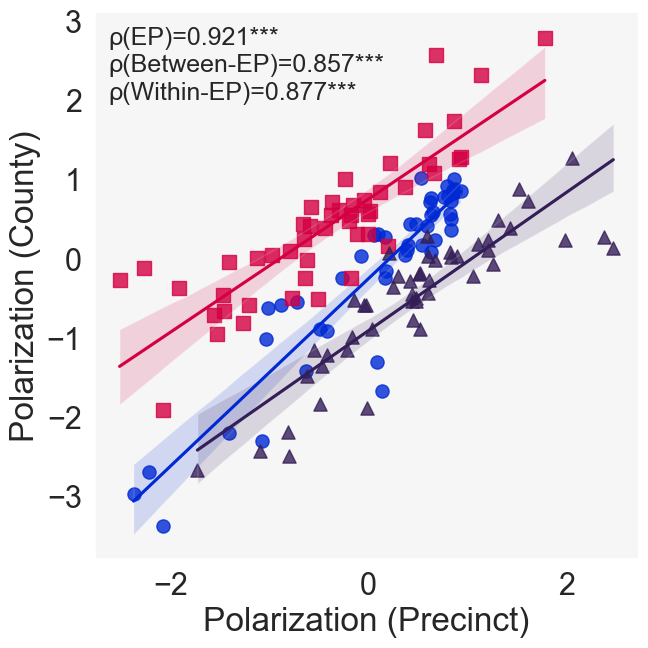

In [ ]:
# fig, ax = plt.subplots(figsize=(7, 7))

sns.set(font_scale=2, rc={"axes.facecolor": "#f6f6f6", "axes.grid" : False})

g = sns.lmplot(
    x="Precinct", y="County", hue="variable", 
    hue_order=["epi", "epi_between", "epi_within"], 
    markers=["o", "s", "^"], 
    scatter_kws={"s": 90},
    palette=["#0029D4", "#D40042", "#341E57"], 
    legend=False,
    data=data2, 
    height=7
)

g.ax.set_xlabel("Polarization (Precinct)")
g.ax.set_ylabel("Polarization (County)")

ax = g.ax

pos = 0.975
for i, dd in data2.groupby("variable"):
    corr, pvalue = pearsonr(dd["Precinct"], dd["County"])
    def corrfunc(corr, pvalue, label):
        ax = plt.gca()
        note = ""
        if pvalue < 0.001:
            note = "***"
        elif pvalue < 0.05:
            note = "**"
        elif pvalue < 0.1:
            note = "*"

        return f"ρ({label})=" + "{:.3f}{}".format(corr, note)
    labels = {"epi": "EP", "epi_between": "Between-EP", "epi_within": "Within-EP"}
    val = corrfunc(corr, pvalue, labels[i])
    ax.text(0.025, pos, val, transform=ax.transAxes, va="top", fontsize=18)
    pos -= 0.05

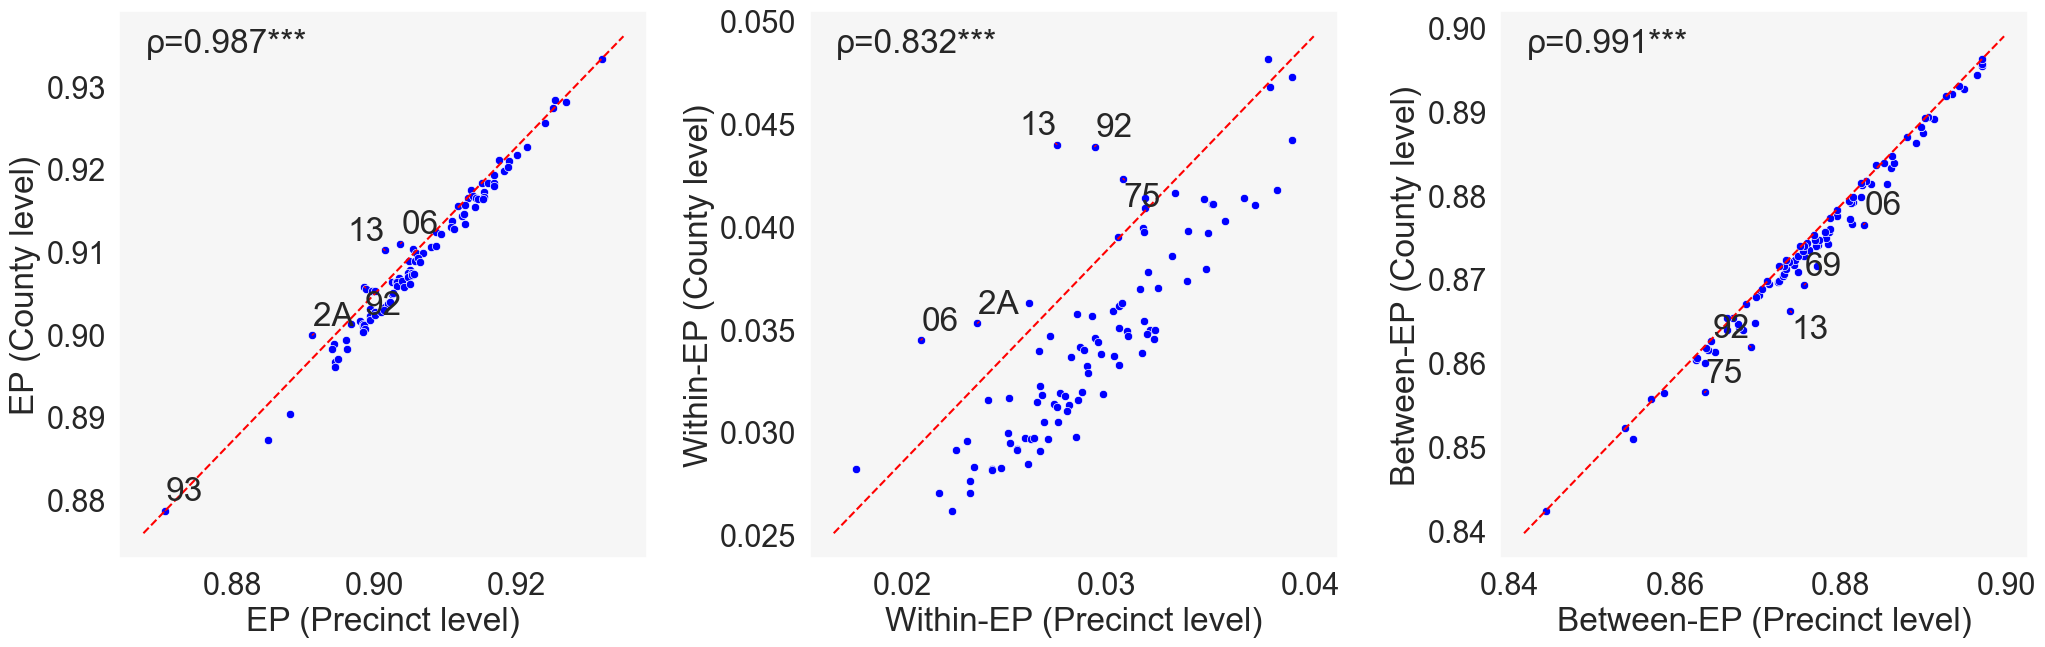

In [ ]:
value_x = "epi_x"
value_y = "epi_y"
level_x = "Precinct"
level_y = "County"

sns.set(font_scale=2, rc={"axes.facecolor": "#f6f6f6", "axes.grid" : False})
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(21, 7))

idx = 0
for value_x, value_y in [("epi_x", "epi_y"), ("epi_within_x", "epi_within_y"), ("epi_between_x", "epi_between_y")]:
    df1["diff"] = np.absolute(df1[value_x] - df1[value_y])
    df1 = df1.sort_values("diff", ascending=False)
    ax = axs[idx]
    idx += 1

    sns.scatterplot(x=value_x, y=value_y, color="blue", data=df1, ax=ax)
    diag_line, = ax.plot(ax.get_xlim(), ax.get_ylim(), color="red", ls="--")

    texts = []
    for i, itm in df1.head().iterrows():
        texts.append(ax.text(itm[value_x], itm[value_y], itm["geography_id"]))

    corr, pvalue = pearsonr(df1[value_x], df1[value_y])
    def corrfunc(corr, pvalue, ax):
        ax = plt.gca()
        note = ""
        if pvalue < 0.001:
            note = "***"
        elif pvalue < 0.05:
            note = "**"
        elif pvalue < 0.1:
            note = "*"

        return "ρ={:.3f}{}".format(corr, note)

    adjust_text(texts=texts, arrowprops=dict(arrowstyle='-', color='red'), ax=ax)
    val = corrfunc(corr, pvalue, ax)

    ax.annotate(val, xy=(.05, .925), xycoords=ax.transAxes)

    if "between" in value_x:
        ax.set_xlabel(f"Between-EP ({level_x} level)")
        ax.set_ylabel(f"Between-EP ({level_y} level)")
    elif "within" in value_x:
        ax.set_xlabel(f"Within-EP ({level_x} level)")
        ax.set_ylabel(f"Within-EP ({level_y} level)")
    else:
        ax.set_xlabel(f"EP ({level_x} level)")
        ax.set_ylabel(f"EP ({level_y} level)")

fig.tight_layout()

In [ ]:
output = []
country = "Chile"
years = [2013, 2017, 2021] if country == "Chile" else [2002, 2007, 2012, 2017, 2022]

for year in years:
    tmp = pd.read_csv(f"data_robustness/{country}/candidates_{year}.csv")
    tmp_cum = pd.read_csv(f"data_robustness/{country}/cumulative_{year}.csv")
    tmp_all = tmp[tmp["N_candidates"] == tmp["N_candidates"].max()]
    for N_candidates, frag in tmp.groupby("N_candidates"):
        aa = pd.merge(frag, tmp_all, on="region_id")
        bb = tmp_cum[tmp_cum["N_candidates"] == N_candidates]["cumulative"].values[0]
        corr, pvalue = pearsonr(aa["value_x"], aa["value_y"])

        output.append({
            "pearson": corr,
            "cumulative": bb,
            "N_candidates": N_candidates,
            "year": year
        })

df = pd.DataFrame(output)
df.head()

,pearson,cumulative,N_candidates,year
0,0.907492,0.717349,2,2013
1,0.962222,0.827212,3,2013
2,0.978962,0.928341,4,2013
3,0.996073,0.956443,5,2013
4,0.999359,0.979925,6,2013


In [ ]:
from scipy.optimize import curve_fit

In [ ]:
-355.29874421 * np.exp(-8.39825906 * 0.9) + 1.08989584

0.9045393222460927

In [ ]:


plt.plot(xdata, ydata, 'b-', label='data')
plt.plot(xdata, func(xdata, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
popt

NameError: name 'xdata' is not defined

C:\Users\cnava\AppData\Roaming\Python\Python310\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\cnava\AppData\Local\Temp\ipykernel_31600\1249235401.py:17: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.lineplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


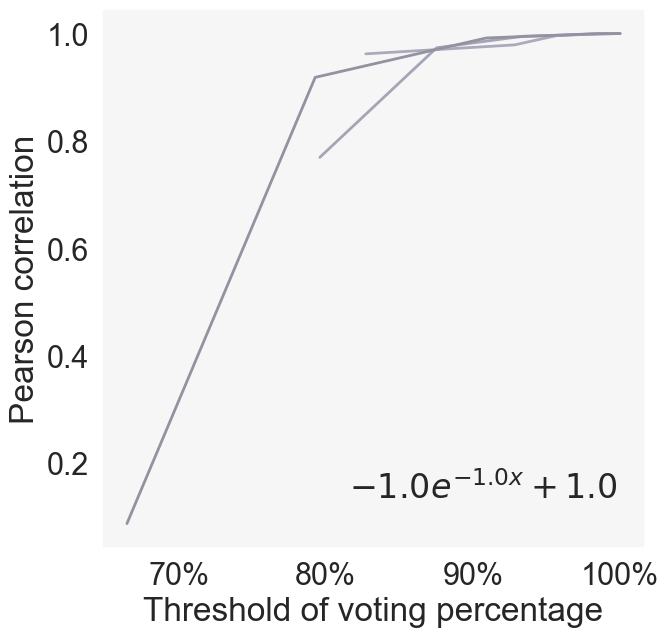

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
import matplotlib.ticker as mtick

dat = df[(df["cumulative"]>=0.68)]
dat = dat.sort_values("cumulative")
xdata = dat.cumulative
ydata = dat.pearson

def func(x, a, b, c):
    return -a * np.exp(-b * x) + c

def func(x, a, b, c):
    return -355.3 * np.exp(-8.4 * x) + 1.1

popt, pcov = curve_fit(func, xdata, ydata)

sns.lineplot(
    x="cumulative", y="pearson", lw=2, 
    # colors="gray",
    palette=["#AAAABC", "#A5A5B7", "#9292A0", "#8E8E99", "#84848D"], 
    legend=False,
    hue="year", data=df[df["N_candidates"]>2]
)

ax.set_ylabel("Pearson correlation")
ax.set_xlabel("Threshold of voting percentage")
# ax.axhline(y=0.8, color="red", ls="--")
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

# sns.lineplot(x=xdata, y=func(xdata, *popt), color="#020A9D", lw=3, ls="--", legend=False)

ax.legend(title=r"""$-%5.1fe^{-%5.1fx} + %5.1f$""" % tuple(popt), frameon=False)

